In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import csv
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
traindf=pd.read_csv("train.csv")
traindf.head()

,user,artist,plays
0,eb1c57ddc9e0e2d005169d3a1a96e8dd95e3af03,5a8e07d5-d932-4484-a7f7-e700793a9c94,554
1,44ce793a6cd9d20f13f4a576a818ef983314bb5d,a3a92047-be1c-4f3e-8960-c4f8570984df,81
2,da9cf3f557161d54b76f24db64be9cc76db008e3,eeb1195b-f213-4ce1-b28c-8565211f8e43,708
3,8fa49ab25d425edcf05d44bfc1d5aea895287d81,a1419808-65d3-4d40-998c-1a0bac65eabc,265
4,b85fcaef67d2669cd99b334b5e8c8705263db2cf,a3cb23fc-acd3-4ce0-8f36-1e5aa6a18432,220


In [3]:
artists_w_genresdf = pd.read_csv("artists_with_genres.csv")
artists_w_genresdf.head()

,Unnamed: 0,artist,name,genre
0,0,03098741-08b3-4dd7-b3f6-1b0bfa2c879c,Liars,alternative rock
1,1,69c4cc43-8163-41c5-ac81-30946d27bb69,CunninLynguists,american
2,2,7a2e6b55-f149-4e74-be6a-30a1b1a387bb,The Desert Sessions,rock and indie
3,3,7002bf88-1269-4965-a772-4ba1e7a91eaa,Glenn Gould,canadian pianist
4,4,dbf7c761-e332-467b-b4d9-aafe06bbcf8f,G. Love & Special Sauce,rock and indie


In [4]:
user_databasedf = pd.read_csv("profiles.csv")
user_databasedf.head(10)

,user,sex,age,country
0,fa40b43298ba3f8aa52e8e8863faf2e2171e0b5d,f,25.0,Sweden
1,5909125332c108365a26ccf0ee62636eee08215c,m,29.0,Iceland
2,d1867cbda35e0d48e9a8390d9f5e079c9d99ea96,m,30.0,United States
3,63268cce0d68127729890c1691f62d5be5abd87c,m,21.0,Germany
4,02871cd952d607ba69b64e2e107773012c708113,m,24.0,Netherlands
5,0938eb3d1b449b480c4e2431c457f6ead7063a34,m,22.0,United States
6,e4c6b36e65db3d48474dd538fe74d2dbb5a2e79e,f,NaN,United States
7,b97479f9a563a5c43b423a976f51fd509e1ec5ba,f,NaN,Poland
8,3bb020df0ff376dfdded4d5e63e2d35a50b3c535,m,NaN,United States
9,f3fb86c0f024f640cae3fb479f3a27e0dd499891,NaN,16.0,Ukraine


### Let's first look at the viability of building an adjacency matrix for the artists

In [5]:
testdf = artists_w_genresdf.groupby('genre')

In [6]:
# Get how many (on average) artists are classified in each genre
print "Mean number of artists in each genre, ", testdf['artist'].count().mean()
print "Median number of artists in each genre, ", testdf['artist'].count().median()

Mean number of artists in each genre,  5.0821529745
Median number of artists in each genre,  1.0


### At first glance the adjacency matrix may not make the most sense
based on the fact that so few artists get grouped into the same genre... There are a lot of genres where there is only one artist, in fact most of them only have one. If we were to extract the list of genres each artist was classified under, it might make more sense.

I'm going to resume in developing some collaborative filtering a la CS109 HW4, first some EDA on the user database

There are 40 people who have negative age (interestingly, they all have age=-1337), there are 625 people who have an age greater than 100, 2 of those are ridiculously set to 666 and 1002. The location of the 1002 year old user is based in Antartica, so it might be worthwhile to just remove that row...

Further analysis showed that there are 606 users under the age of 8. I'm making a pretty strong assumption that these aren't valid users or their relative/friend also uses the account, notwithstanding that some of these people may be those who may have missed entering a digit when they signed up

Also, there are 429 users who are signed up who are over the age of 65. I'm going to also assume that these are spoofed ages as well.

In [7]:
fixed_age_databasedf = user_databasedf.copy()
fixed_age_databasedf.loc[(user_databasedf.age <= 0) | (user_databasedf.age > 100),'age'] = None

In [8]:
print fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()].min()
print fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()].max()

1.0
100.0


Our user's median age is (now):  23.0
with mean age:  24.5247338627


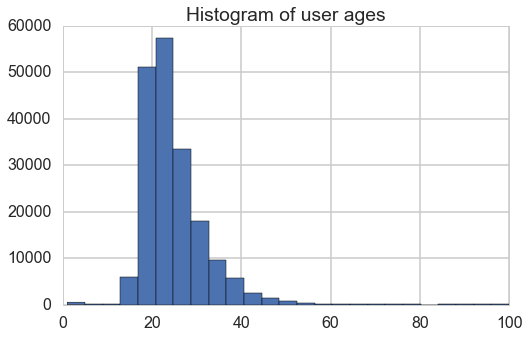

In [9]:
print "Our user's median age is (now): ", fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()].median()
print "with mean age: ", fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()].mean()
plt.figure(figsize=(8,5))
plt.hist(fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()],bins=25)
plt.title("Histogram of user ages")
plt.show()

Looking at the histogram here makes me want to further restrict the ages between 15 and 60 years old. We can impute the average age for the user (male or female, by country) in all of these cases.

In [10]:
len(user_databasedf.age[(user_databasedf.age < 8) & (user_databasedf.age>=0)])

606

In [11]:
len(user_databasedf.age[(user_databasedf.age > 65) & (user_databasedf.age<=100)])

429

In [12]:
fixed_age_databasedf.loc[(user_databasedf.age <= 8) | (user_databasedf.age > 65),'age'] = None

Our user's median age is (now):  23.0
with mean age:  24.4553551345


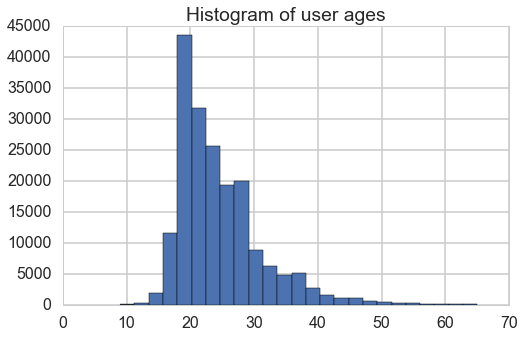

In [13]:
print "Our user's median age is (now): ", fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()].median()
print "with mean age: ", fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()].mean()
plt.figure(figsize=(8,5))
plt.hist(fixed_age_databasedf.age[~fixed_age_databasedf.age.isnull()],bins=25)
plt.title("Histogram of user ages")
plt.show()

That looks a lot cleaner to me. I'm going to keep moving with this dataframe and will fill the ages in (by Country, if available) according the distribution of their gender. 

Let's first look at what those histograms may look like for the dataset in general (regardless of nation)

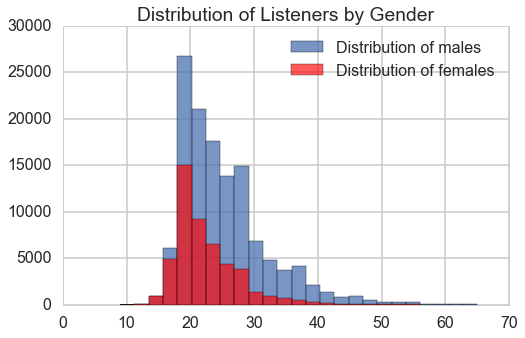

In [14]:
plt.figure(figsize=(8,5))
plt.hist(fixed_age_databasedf.age[(~fixed_age_databasedf.age.isnull())  & (fixed_age_databasedf.sex == 'm')],alpha=0.75,label='Distribution of males',bins=25)
plt.hist(fixed_age_databasedf.age[(~fixed_age_databasedf.age.isnull())  & (fixed_age_databasedf.sex == 'f')], color='red',alpha=0.65,label='Distribution of females',bins=25)
plt.title("Distribution of Listeners by Gender")
plt.legend()
plt.show()

That's looking pretty good! Now let's see how this changes for a specified country. Let's say Sweden?

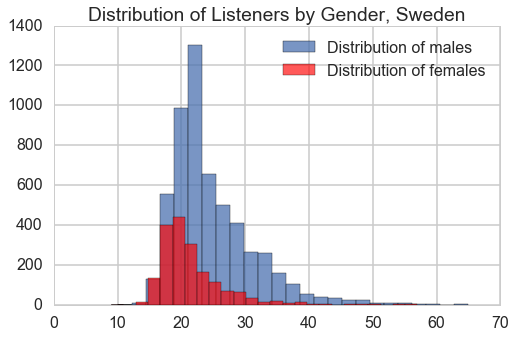

In [15]:
plt.figure(figsize=(8,5))
plt.hist(fixed_age_databasedf.age[(~fixed_age_databasedf.age.isnull()) & ((~fixed_age_databasedf.sex.isnull()) & (fixed_age_databasedf.sex == 'm')) & (fixed_age_databasedf.country=='Sweden')],alpha=0.75,label='Distribution of males',bins=25)
plt.hist(fixed_age_databasedf.age[(~fixed_age_databasedf.age.isnull()) & ((~fixed_age_databasedf.sex.isnull()) & (fixed_age_databasedf.sex == 'f')) & (fixed_age_databasedf.country=='Sweden')], color='red',alpha=0.65,label='Distribution of females',bins=25)
plt.title("Distribution of Listeners by Gender, Sweden")
plt.legend()
plt.show()

Okay, how about Poland?

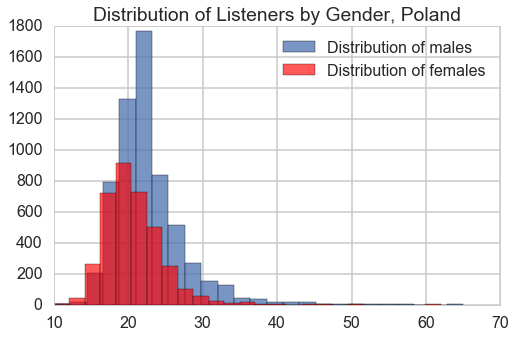

In [16]:
plt.figure(figsize=(8,5))
plt.hist(fixed_age_databasedf.age[(~fixed_age_databasedf.age.isnull()) & ((~fixed_age_databasedf.sex.isnull()) & (fixed_age_databasedf.sex == 'm')) & (fixed_age_databasedf.country=='Poland')],alpha=0.75,label='Distribution of males',bins=25)
plt.hist(fixed_age_databasedf.age[(~fixed_age_databasedf.age.isnull()) & ((~fixed_age_databasedf.sex.isnull()) & (fixed_age_databasedf.sex == 'f')) & (fixed_age_databasedf.country=='Poland')], color='red',alpha=0.65,label='Distribution of females',bins=25)
plt.title("Distribution of Listeners by Gender, Poland")
plt.legend()
plt.show()

### Now, let's fill the age column of the listeners by gender and nation. 
Now we want to account for all conditions:
* where there's no gender (sample from the distribution of the country)
* where there's no nation (sample from the distribution of male/female)
* where there's neither (sample from the distribution of ages)

In [22]:
fixed_age_databasedf.loc[61]

user       6ad6d1c283dacbdc7d78bb74995a0e5e27a79c0d
sex                                               m
age                                             NaN
country                               United States
Name: 61, dtype: object

In [23]:
def fill_ages(indf):
    '''This helper function takes in a cleaned dataframe (with columns: user, age, sex and country)
    where invalid ages have been replaced with null values. This function infers a user's age based
    on their country and gender. If one or both of those is missing, the inference is performed on 
    the most informative subset of the data we have (at worst this is the entire dataset).'''
    # First copy dataframe for safety's sake
    outdf = indf.copy()
    
    # Loop through the entries in the data frame that have null valued age
    for index, (user_id,gender,age,country) in indf[indf.age.isnull()].iterrows():
        
        # Build up conditions over which we're calculating distribution of ages for this particular user
        #nans won't equal themselves
        if gender != gender:       # gender is not present
            if country != country: # country isn't present either
                
                condition = (~indf.age.isnull())
            else:
                
                condition = (~indf.age.isnull()) & (~indf.sex.isnull()) & (indf.country == country)
        elif country != country:   # country isn't present
            
            condition = (~indf.age.isnull()) & (indf.sex == gender)
        else:                      # both are present
            
            condition = (~indf.age.isnull()) & (indf.sex == gender) & (indf.country == country)
        
        # Extract array of ages relevant to the current user, based on country and gender (if available)
        relevant_ages = np.array(indf.age[condition]).astype('int64')
        relevant_ages_aggregated = np.bincount(relevant_ages)
        # Normalize to create a distribution (assuming that it's continuous between low and high (no need for pseudocounts))
        normed_ages = relevant_ages_aggregated/float(np.sum(relevant_ages_aggregated))
        
        # Found that there are some edge cases where there are few users from nation x that all have no age... 
        # Recalculate distribution
        if len(normed_ages) == 0: 
            if gender != gender:
                condition = (~indf.age.isnull()) & (~indf.sex.isnull())
            else:
                condition = (~indf.age.isnull()) & (indf.sex == gender)
            relevant_ages = np.array(indf.age[condition]).astype('int64')
            relevant_ages_aggregated = np.bincount(relevant_ages)
            normed_ages = relevant_ages_aggregated/float(np.sum(relevant_ages_aggregated))
            
        # Randomly assign user age based on distribution
        new_age = np.random.choice(range(len(normed_ages)),size=1,replace=True,p=normed_ages)[0]
        outdf.loc[index,'age'] = new_age
    
    # Return filled dataframe
    return outdf

In [24]:
complete_age_databasedf = fill_ages(fixed_age_databasedf)

In [25]:
fixed_age_databasedf.head(10)

,user,sex,age,country
0,fa40b43298ba3f8aa52e8e8863faf2e2171e0b5d,f,25.0,Sweden
1,5909125332c108365a26ccf0ee62636eee08215c,m,29.0,Iceland
2,d1867cbda35e0d48e9a8390d9f5e079c9d99ea96,m,30.0,United States
3,63268cce0d68127729890c1691f62d5be5abd87c,m,21.0,Germany
4,02871cd952d607ba69b64e2e107773012c708113,m,24.0,Netherlands
5,0938eb3d1b449b480c4e2431c457f6ead7063a34,m,22.0,United States
6,e4c6b36e65db3d48474dd538fe74d2dbb5a2e79e,f,NaN,United States
7,b97479f9a563a5c43b423a976f51fd509e1ec5ba,f,NaN,Poland
8,3bb020df0ff376dfdded4d5e63e2d35a50b3c535,m,NaN,United States
9,f3fb86c0f024f640cae3fb479f3a27e0dd499891,NaN,16.0,Ukraine


In [26]:
complete_age_databasedf.head(10)

,user,sex,age,country
0,fa40b43298ba3f8aa52e8e8863faf2e2171e0b5d,f,25.0,Sweden
1,5909125332c108365a26ccf0ee62636eee08215c,m,29.0,Iceland
2,d1867cbda35e0d48e9a8390d9f5e079c9d99ea96,m,30.0,United States
3,63268cce0d68127729890c1691f62d5be5abd87c,m,21.0,Germany
4,02871cd952d607ba69b64e2e107773012c708113,m,24.0,Netherlands
5,0938eb3d1b449b480c4e2431c457f6ead7063a34,m,22.0,United States
6,e4c6b36e65db3d48474dd538fe74d2dbb5a2e79e,f,17.0,United States
7,b97479f9a563a5c43b423a976f51fd509e1ec5ba,f,19.0,Poland
8,3bb020df0ff376dfdded4d5e63e2d35a50b3c535,m,26.0,United States
9,f3fb86c0f024f640cae3fb479f3a27e0dd499891,NaN,16.0,Ukraine


In [27]:
len(complete_age_databasedf[complete_age_databasedf.age.isnull()])

0

In [28]:
complete_age_databasedf[complete_age_databasedf.age.isnull()]

,user,sex,age,country


In [30]:
#Save filled dataframe to file
complete_age_databasedf.to_csv("complete_age_profiles.csv")